<a href="https://colab.research.google.com/github/mdacoca/da_portfolio/blob/de_camp/mobile_plan_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finidng the best paid plan for a telecom company


The "Call me" Company - is a mobile operator, that offers customers two paid plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which plan brings in more money.

It is necessary to do a preliminary analysis of both plans on a small sample of clients. I have data of 500 "Call me" clients: who they are, where they are from, which pman they use, how many calls and messages each sent in 2018. It is necessary to analyze the behavior of customers and make a conclusion - which plan is better.

## Plan Descriptions

**Smart**

1. Monthly fee: 550 rubles
2. Includes 500 minutes of conversation, 50 messages, and 15 GB of internet traffic
3. Cost of services beyond the tariff package:
    * conversation minute: 3 rubles
    * message: 3 rubles
    * 1 GB of internet traffic: 200 rubles

**Ultra**

1. Monthly fee: 1950 rubles
2. Includes 3000 minutes of conversation, 1000 messages, and 30 GB of internet traffic
3. Cost of services beyond the tariff package:
    * conversation minute: 1 ruble
    * message: 1 ruble
    * 1 GB of internet traffic: 150 rubles

> "Call me" always rounds up the values of minutes and megabytes. If a user only spoke for 1 second, a whole minute is counted in the tariff.


## Data Description

Users table (user information):
* `user_id` — unique user identifier
* `first_name` — user's first name
* `last_name` — user's last name
* `age` — user's age (years)
* `reg_date` — tariff start date (day, month, year)
* `churn_date` — the date the user stopped using the tariff (if the value is missing, the tariff was still in effect at the time of data extraction)
* `city` — user's city of residence
* `tariff` — tariff plan name

Calls table (call information):

* `id` — unique call number
* `call_date` — call date
* `duration` — call duration in minutes
* `user_id` — identifier of the user who made the call

Messages table (message information):

* `id` — unique message number
* `message_date` — message date
* `user_id` — identifier of the user who sent the message

Internet table (internet session information):

* `id` — unique session number
* `mb_used` — amount of internet traffic used during the session (in megabytes)
* `session_date` — internet session date
* `user_id` — user identifier

Plans table (tariff information):

* `tariff_name` — tariff name
* `rub_monthly_fee` — monthly subscription fee in rubles
* `minutes_included` — number of call minutes per month included in the subscription fee
* `messages_included` — number of messages per month included in the subscription fee
* `mb_per_month_included` — amount of internet traffic included in the subscription fee (in megabytes)
* `rub_per_minute` — cost of a call minute beyond the tariff package (for example, if the tariff includes 100 minutes of calls per month, a fee will be charged from the 101st minute)
* `rub_per_message` — cost of sending a message beyond the tariff package
* `rub_per_gb` — cost of an additional gigabyte of internet traffic beyond the tariff package (1 gigabyte = 1024 megabytes)


## Tasks

1. Describe the behavior of the operator's customers based on the sample:
    * How many minutes of conversation, how many messages, and what volume of internet traffic do users of each tariff need per month?
    * Calculate the average number, variance, and standard deviation.
    * Draw histograms. Describe the distributions.
2. Test the hypotheses:
    * the average revenue of "Ultra" and "Smart" tariff users is different;
    * the average revenue of users from Moscow differs from the revenue of users from other regions;
3. Explain:
    * how you formulated the null and alternative hypotheses;
    * which criterion you used to test the hypotheses and why.
4. General conclusion


# 
Data Preparation

In [186]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [187]:
# libraries import
import pandas as pd
import numpy as np
from datetime import datetime
from scipy import stats as st
pd.options.mode.chained_assignment = None  # default='warn'
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  
from pymystem3 import Mystem
from matplotlib import pyplot as plt
m = Mystem()

In [188]:
# data import
users = pd.read_csv('/content/drive/MyDrive/da_portfolio/users.csv')
calls = pd.read_csv('/content/drive/MyDrive/da_portfolio/calls.csv')
messages = pd.read_csv('/content/drive/MyDrive/da_portfolio/messages.csv')
internet = pd.read_csv('/content/drive/MyDrive/da_portfolio/internet.csv')
tariffs = pd.read_csv('/content/drive/MyDrive/da_portfolio/tariffs.csv')


Since the data is in several tables, I will need to combine them into one based on the `user_id` column, which can be used to join the `users`, `calls`, `internet`, `messages` tables.

Before joining the tables, it is necessary to check for missing values, duplicates, and correct (if necessary) data types in all tables.

## Users 


The `users` table contains information about the customers - id, registration date, full name, and so on:


In [189]:
# checking the data type and missing values
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [190]:
# checking the data type and missing values visually
users.sample(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
329,1329,36,NaN,Набережные Челны,Юна,Золотова,2018-10-08,smart
286,1286,19,NaN,Москва,Рашид,Троицкий,2018-11-27,smart
281,1281,62,NaN,Нижний Новгород,Сара,Зимина,2018-06-09,ultra
25,1025,56,NaN,Уфа,Матвей,Акинин,2018-03-15,smart
48,1048,73,NaN,Новокузнецк,Лола,Мясникова,2018-08-19,ultra
319,1319,70,NaN,Санкт-Петербург,Харитон,Парфенов,2018-08-24,smart
314,1314,27,NaN,Киров,Максим,Амелишко,2018-03-04,smart
176,1176,37,NaN,Волгоград,Радим,Куприянов,2018-01-20,smart
86,1086,73,NaN,Волгоград,Ириней,Аксёнов,2018-04-26,smart
405,1405,54,NaN,Набережные Челны,Элина,Белова,2018-10-08,ultra


From the data, it is clear that some customers stopped using the services of the operator by the time of data extraction. Since such customers were using the tariff for a while, I need the data that is available for these customers, regardless of whether they are using the operator now or not. Missing values in the `churn_date` column do not interfere with the analysis, since I am not using this column, so I leave the column unchanged.


In [191]:
# checking for duplicates
users.duplicated().sum()

0

From the information about the table, I see that `reg_date` has a data type `object`, which needs to be replaced with `datetime`:


In [192]:
# chancgin data type from object to datetime:
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

Since there is a column with city names, let's check this column for errors, typos, etc.:

In [193]:
# checking the unique names visually
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

All names look unique, there are no errors or typos, everything is ok.

## Calls 

The `calls` table contains information about calls - id, duration, date, and so on:

In [194]:
# checking information 
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


The index and the number of rows in each column match - there are no missing values.

In [195]:
# visual check
calls.sample(10)

,id,call_date,duration,user_id
157301,1389_166,2018-10-11,0.00,1389
65007,1168_158,2018-06-12,3.17,1168
78275,1196_507,2018-06-14,14.19,1196
184397,1457_369,2018-08-22,0.28,1457
151004,1378_91,2018-12-14,12.73,1378
2716,1006_425,2018-05-24,0.78,1006
77030,1193_292,2018-07-01,0.00,1193
11424,1029_313,2018-12-11,0.00,1029
174239,1430_288,2018-09-18,8.66,1430
88656,1222_394,2018-09-13,8.80,1222


In [196]:
# checking for duplicates
calls.duplicated().sum()

0

From the information about the table, I see that `call_date` has a data type `object`, which needs to be replaced with `datetime`:


In [197]:
# changing the data type from  object to datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In the table, there are many calls with a duration of 0.00. In our conditions, it is stated that the operator always rounds up the values of minutes, not down. This means that calls with a duration of 0.00 cannot be calls that lasted less than a minute. Most likely, these are calls that failed or calls that the customer did not accept (did not pick up the phone). To decide what to do with them, I look at the number of such calls and how it will look on the histogram (it's more visual this way).

In [198]:
# total nuber of 0 00 calls
calls.query('duration == 0.0').count()

id           39613
call_date    39613
duration     39613
user_id      39613
dtype: int64

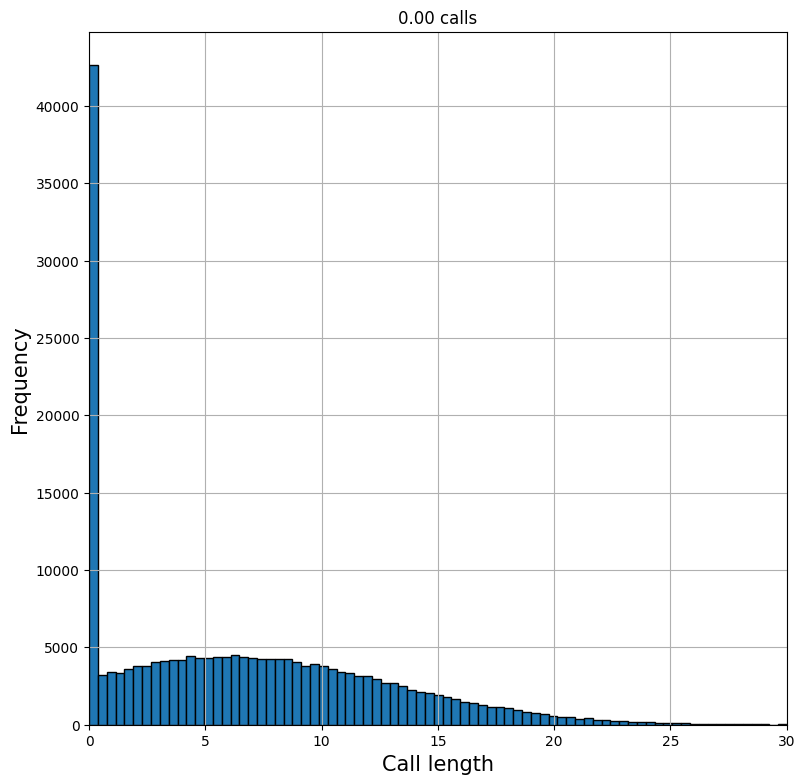

In [199]:
# hist visualisation of 0 00 calls
calls['duration'].plot(kind='hist', ec='black',  bins=100, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('0.00 calls')
plt.show()


There are too many zero values, they will affect the average value and results in further analysis. Moreover, the operator will not receive any revenue for calls with a duration of 0.00 minutes, so I delete such values from the table

In [200]:
# renoving 0 00 values from the table
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()


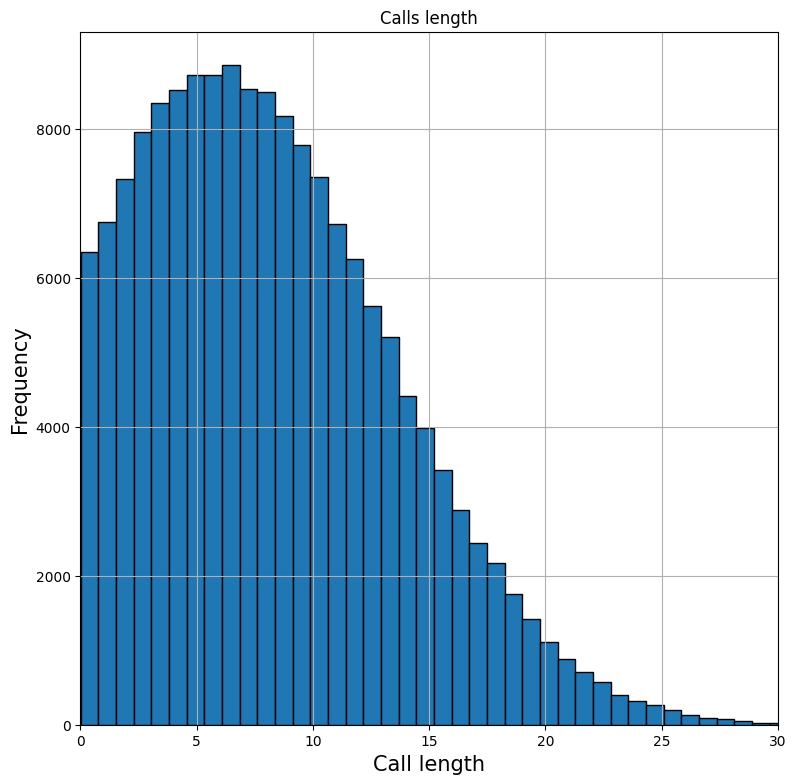

In [201]:
# checking the hist visualisation 
calls['duration'].plot(kind='hist', ec='black', bins=50, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('Calls length')
plt.show()


There are no zeros that stand out from the overall distribution, but there are many near-zero values. To understand what is happening, I check the minimum value in the column.

In [202]:
# checking the minimal value in the column
calls['duration'].min()

0.01


Since we know that the operator will round up values like 0.01 to a minute, we round up all values in the column to an integer and change the data type so there is no floating point.

In [203]:
# rounding up and changing the data type
calls['duration'] = calls['duration'].apply(np.ceil).astype(int)

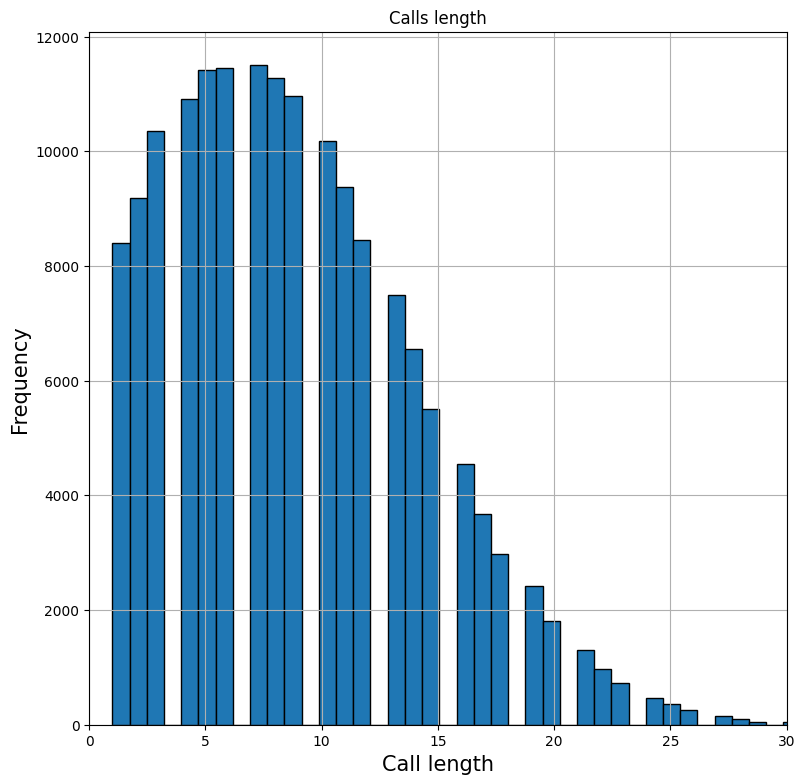

In [204]:
# now cheking the looks again
calls['duration'].plot(kind='hist', ec='black', bins=50, figsize=(9, 9), grid=True)
plt.xlabel('Call length', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 30])
plt.title('Calls length')
plt.show()

The histogram shows that there are no calls with a duration of 0 or close to 0.

## Messages 

The `messages` table contains information about calls - id, quantity, date, etc:


In [205]:
# checking table info
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


The index and the number of rows in each column match - there are no missing values.

In [206]:
# visual check
messages.sample(10)

,id,message_date,user_id
72796,1308_256,2018-09-05,1308
19174,1083_363,2018-07-13,1083
32243,1144_382,2018-08-03,1144
100443,1411_279,2018-09-14,1411
1812,1004_866,2018-11-14,1004
4407,1016_87,2018-11-25,1016
70423,1300_175,2018-12-19,1300
65874,1282_306,2018-11-10,1282
21556,1091_109,2018-06-08,1091
72856,1308_316,2018-07-14,1308


In [207]:
# checking for duplicates
messages.duplicated().sum()

0

From the information about the table, I see that `message_date` has a data type `object`, which needs to be replaced with `datetime`:


In [208]:
# changing data type from  object to datetime:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

## Internet

The `internet` table contains information about the volumes of internet traffic used by customers - id, session date, amount of traffic in mb, etc.

In [209]:
# checking the table info
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


The index and the number of rows in each column match - there are no missing values.

In [210]:
# visual check
internet.sample(10)

,Unnamed: 0,id,mb_used,session_date,user_id
116103,116103,1391_236,48.66,2018-05-13,1391
133141,133141,1444_70,277.71,2018-12-23,1444
105102,105102,1356_101,580.88,2018-07-04,1356
28553,28553,1099_217,867.67,2018-09-02,1099
134193,134193,1450_76,0.00,2018-12-21,1450
24609,24609,1084_37,357.15,2018-12-25,1084
68597,68597,1233_56,69.35,2018-10-31,1233
34950,34950,1121_308,697.38,2018-07-25,1121
68717,68717,1233_176,0.00,2018-11-01,1233
7320,7320,1025_212,0.00,2018-06-24,1025


In [211]:
# checking for duplicates
internet.duplicated().sum()

0

From the information about the table, I see that `session_date` has a data type object, which needs to be replaced with datetime.

In [212]:
# changing datatype object to datetime:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")


I'm checking the table for the number of internet sessions with 0.00 mb of downloaded data.

The absence of traffic upon connection means that the session was interrupted immediately after connection for some reason, or the customer was unable to connect. Sessions with a volume of 0.00 mb cannot be sessions in which less than 1 mb of data was downloaded (remember about rounding up). To decide what to do with them, I look at the number of such sessions and how it will look on the histogram (this is more illustrative).

In [213]:
# overall number of sessions 
internet.query('mb_used == 0.0').count()

Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64

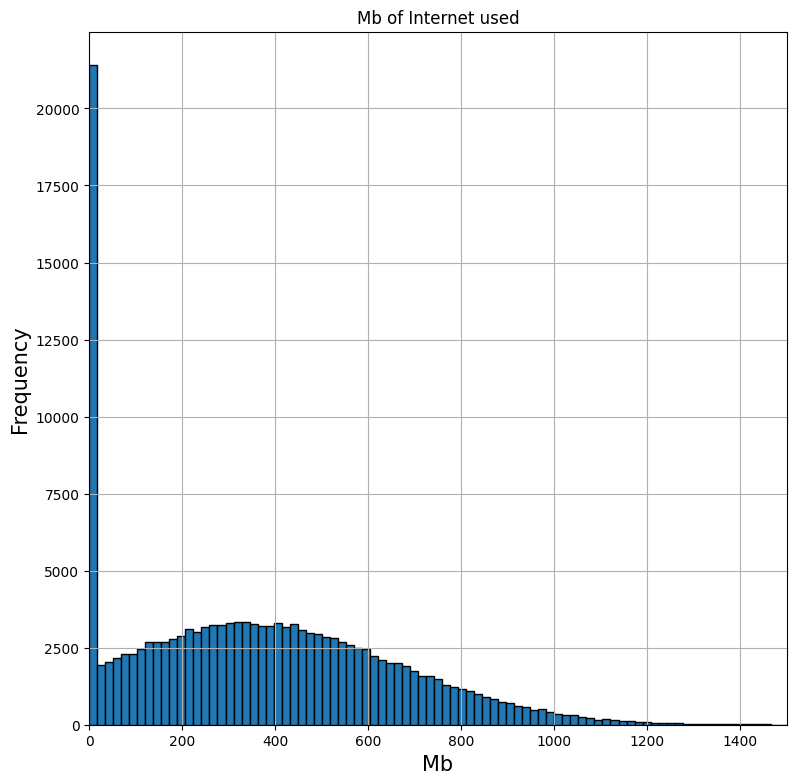

In [214]:
# checking the hist view
internet['mb_used'].plot(kind='hist', ec='black', bins=100, figsize=(9, 9), grid=True)
plt.xlabel('Mb', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Mb of Internet used')
plt.xlim([0, 1500])
plt.show()

There are too many zero values, in further analysis they will affect the average value and results. Moreover, for sessions with 0.00 mb of traffic, the operator will not receive any revenue, so I remove such values from the table, and round up the rest.

In [215]:
# rounding up and changing data type
internet['mb_used'] = internet['mb_used'].apply(np.ceil).astype(int)

In [216]:
# removing zero values from the table
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

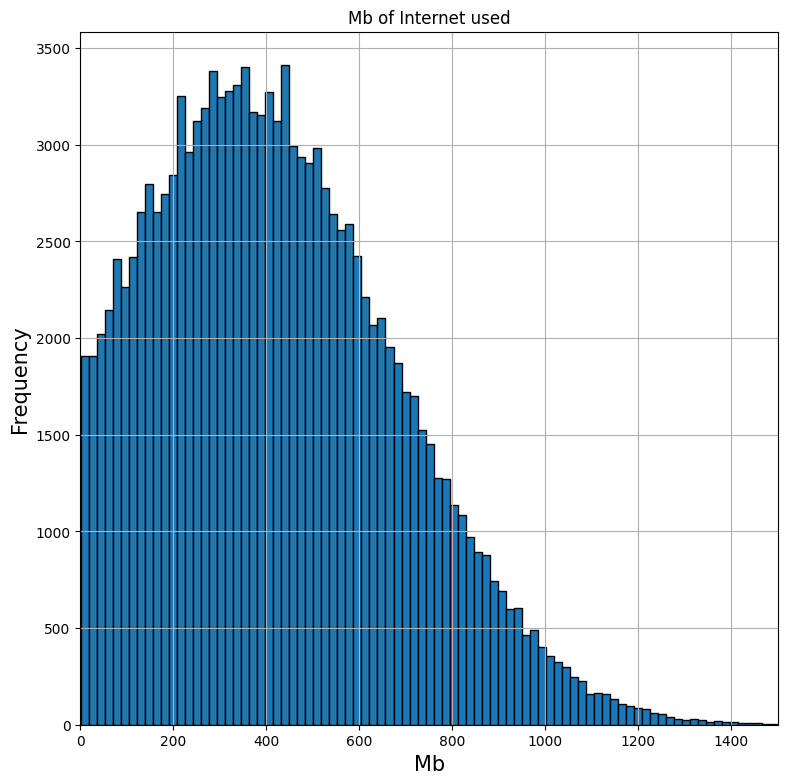

In [217]:
# checking the hist view
internet['mb_used'].plot(kind='hist', ec='black', bins=100, figsize=(9, 9), grid=True)
plt.xlabel('Mb', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Mb of Internet used')
plt.xlim([0, 1500])
plt.show()


There are no zeros that stand out from the general distribution, but there are many near-zero values. To understand what is happening, I check the minimum value in the column.

In [218]:
# checking what is the mininal value
internet['mb_used'].min()

1.0

## Plans


Lets start with checking the general information about paid plans.

In [219]:
# checking the info
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [220]:
# checking visually
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [221]:
# меняю название столбца, чтобы проще было объединять таблицы
tariffs.columns =['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff']


**Conclusion**: The data is prepared for processing, missing values and outliers have been removed, data types have been corrected, and other deficiencies that could distort the analysis results have been eliminated.

# Calculating the use of plans by clients (by months)

## Calls 

How many minutes of conversation are needed by clients of each tariff per month.


In [222]:
# adding a column with month
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [223]:
# Creating a new table with the number and duration of calls for each client by months
calls_month = pd.pivot_table(calls, index=['user_id','month'],
                                    values=['duration','id'],
                                    aggfunc={'duration':sum,'id':'count'}
                             ).reset_index()
# changing the columns names
calls_month.columns =['user_id', 'month', 'duration', 'calls_amount']

# checking results
calls_month.sample(10)

,user_id,month,duration,calls_amount
1446,1228,9,428,47
2395,1381,8,654,73
52,1006,12,379,44
166,1025,8,444,52
885,1144,5,541,60
3054,1480,3,425,52
2169,1346,12,869,111
387,1061,10,588,64
327,1053,9,1,1
245,1039,8,398,46


## Messages


Number of messages sent per month.

In [224]:
# adding a column with month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month


In [225]:
# Creating a new table with the number of messages for each client by month.
messages_month = pd.pivot_table(messages, index=['user_id','month'],
                                          values='id',
                                          aggfunc='count'
                                ).reset_index()

# changing the column names
messages_month.columns =['user_id', 'month', 'messages_amount']

# checking results
messages_month.sample(10)

,user_id,month,messages_amount
1262,1245,9,65
190,1034,9,37
857,1164,6,37
284,1054,11,62
792,1149,5,34
1549,1300,7,33
1369,1268,5,4
2706,1497,10,20
353,1065,9,58
900,1171,7,68


## Internet 

Amount of traffic by month.

In [226]:
# adding the column with month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month


In [227]:
# Creating a new table with the amount of mb for each client by month
internet_month = pd.pivot_table(internet, index=['user_id','month'],
                                          values='mb_used',
                                          aggfunc='sum'
                                ).reset_index()


# checking results
internet_month.sample(10)

,user_id,month,mb_used
1086,1172,7,29495.0
2086,1330,9,29680.0
2518,1394,12,5817.0
1201,1187,8,5588.0
2015,1319,11,18358.0
2431,1382,10,10532.0
155,1023,10,7035.0
2468,1388,12,21844.0
1286,1201,9,12206.0
2598,1407,11,11343.0


## Pivot table with calculations

I'm merging all the tables into one to make it easier to calculate the monthly revenue per customer.

In [228]:
# merge call and internet data
clients_total = calls_month.merge(internet_month, on=['user_id','month'], how ='outer')

# add message data
clients_total = clients_total.merge(messages_month, on=['user_id','month'], how ='outer')

# add client information
clients_total = clients_total.merge(users[['user_id','tariff', 'city']], on='user_id', how ='left')

# add tariff information
clients_total = clients_total.merge(tariffs, on='tariff', how='left')

# check the result
clients_total.sample(10)


,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
1413,1225,4,41.0,9.0,4550.0,NaN,ultra,Оренбург,1000,30720,3000,1950,150,1,1
740,1119,4,65.0,8.0,8836.0,13.0,smart,Петрозаводск,50,15360,500,550,200,3,3
1469,1235,11,481.0,69.0,15622.0,66.0,smart,Москва,50,15360,500,550,200,3,3
1213,1190,12,445.0,52.0,12067.0,20.0,smart,Москва,50,15360,500,550,200,3,3
2238,1359,11,741.0,81.0,16803.0,12.0,smart,Москва,50,15360,500,550,200,3,3
2984,1470,10,255.0,30.0,10543.0,7.0,smart,Новокузнецк,50,15360,500,550,200,3,3
2853,1452,9,194.0,20.0,21731.0,62.0,ultra,Москва,1000,30720,3000,1950,150,1,1
2609,1412,9,567.0,73.0,29516.0,54.0,ultra,Волгоград,1000,30720,3000,1950,150,1,1
482,1076,11,541.0,64.0,13816.0,93.0,smart,Уфа,50,15360,500,550,200,3,3
486,1077,12,784.0,83.0,24143.0,32.0,smart,Москва,50,15360,500,550,200,3,3


I see that there are missing values, I'm checking how many there are.

In [229]:
# merged table info
clients_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   duration               3168 non-null   float64
 3   calls_amount           3168 non-null   float64
 4   mb_used                3201 non-null   float64
 5   messages_amount        2717 non-null   float64
 6   tariff                 3214 non-null   object 
 7   city                   3214 non-null   object 
 8   messages_included      3214 non-null   int64  
 9   mb_per_month_included  3214 non-null   int64  
 10  minutes_included       3214 non-null   int64  
 11  rub_monthly_fee        3214 non-null   int64  
 12  rub_per_gb             3214 non-null   int64  
 13  rub_per_message        3214 non-null   int64  
 14  rub_per_minute         3214 non-null   int64  
dtypes: f

There are missing values, apparently some customers used the tariff only to make calls, so they have no used traffic and so on. Let's look at the number of missing values in each column.

In [230]:
# checking the missing data
pd.DataFrame(round((clients_total.isna().mean()*100),2)).style.background_gradient('coolwarm')

,0
user_id,0.000000
month,0.000000
duration,1.430000
calls_amount,1.430000
mb_used,0.400000
messages_amount,15.460000
tariff,0.000000
city,0.000000
messages_included,0.000000
mb_per_month_included,0.000000



15% is a lot, so for `messages_amount` I'm replacing the missing values with 0, and for the rest I'm deleting them.

In [231]:
# filling n/a with 0
clients_total['messages_amount'].fillna(0, inplace=True)

# deleting where I can delete
clients_total.dropna(subset=['duration', 'calls_amount', 'mb_used'], inplace=True)

# checking results
clients_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3155 entries, 0 to 3167
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3155 non-null   int64  
 1   month                  3155 non-null   int64  
 2   duration               3155 non-null   float64
 3   calls_amount           3155 non-null   float64
 4   mb_used                3155 non-null   float64
 5   messages_amount        3155 non-null   float64
 6   tariff                 3155 non-null   object 
 7   city                   3155 non-null   object 
 8   messages_included      3155 non-null   int64  
 9   mb_per_month_included  3155 non-null   int64  
 10  minutes_included       3155 non-null   int64  
 11  rub_monthly_fee        3155 non-null   int64  
 12  rub_per_gb             3155 non-null   int64  
 13  rub_per_message        3155 non-null   int64  
 14  rub_per_minute         3155 non-null   int64  
dtypes: f

In [232]:
# checking for duplicates
clients_total.duplicated().sum()

0


The table is ready for further analysis and calculations.

Let's calculate the monthly revenue from each customer and add the result in a separate column.

In [233]:
# function to calculate expences above the plan

def extra_expenses(row):
    ex_minutes = (row['calls_amount'] - row['minutes_included']) * row['rub_per_minute']
    ex_gb = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024
    ex_messages = (row['messages_amount'] - row['messages_included']) * row['rub_per_message']
    extra = 0
    for y in [ex_minutes, ex_gb, ex_messages]:
              if y > 0:
                extra +=y
    return extra
    

In [234]:
# adding results to separate column
clients_total['extra_expenses'] = clients_total.apply(lambda x: extra_expenses(x), axis=1)

In [235]:
# calculating overall income and checking the result
clients_total['income'] = clients_total['extra_expenses'] + clients_total['rub_monthly_fee']
clients_total['income'] = clients_total['income'].astype(int)
clients_total.sample(10)


,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_expenses,income
3099,1486,11,764.0,84.0,36319.0,96.0,smart,Нижний Новгород,50,15360,500,550,200,3,3,4231.554688,4781
667,1107,11,224.0,24.0,22551.0,0.0,smart,Орёл,50,15360,500,550,200,3,3,1404.492188,1954
1898,1303,7,101.0,15.0,2698.0,7.0,ultra,Смоленск,1000,30720,3000,1950,150,1,1,0.000000,1950
2816,1443,9,407.0,38.0,3518.0,10.0,smart,Казань,50,15360,500,550,200,3,3,0.000000,550
1181,1186,9,668.0,79.0,12526.0,81.0,smart,Самара,50,15360,500,550,200,3,3,93.000000,643
2277,1366,6,166.0,18.0,4746.0,19.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,0.000000,550
3011,1474,12,1345.0,132.0,42356.0,105.0,ultra,Набережные Челны,1000,30720,3000,1950,150,1,1,1704.492188,3654
219,1034,9,730.0,81.0,17316.0,37.0,smart,Вологда,50,15360,500,550,200,3,3,382.031250,932
3073,1482,3,444.0,44.0,13125.0,63.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3,39.000000,589
2373,1378,11,437.0,53.0,10476.0,9.0,smart,Иркутск,50,15360,500,550,200,3,3,0.000000,550


# Exploratory Analysis of the Plans

How many minutes of conversation, how many messages, and what volume of internet traffic do users of each tariff need per month?

For convenience, I will create separate tables for tariffs.

In [236]:
# separate tables by plan
smart = clients_total[clients_total['tariff'] == 'smart']
ultra = clients_total[clients_total['tariff'] == 'ultra']

## Calls 

Смотрю информацию по минутам разговора для тарифа Ultra.

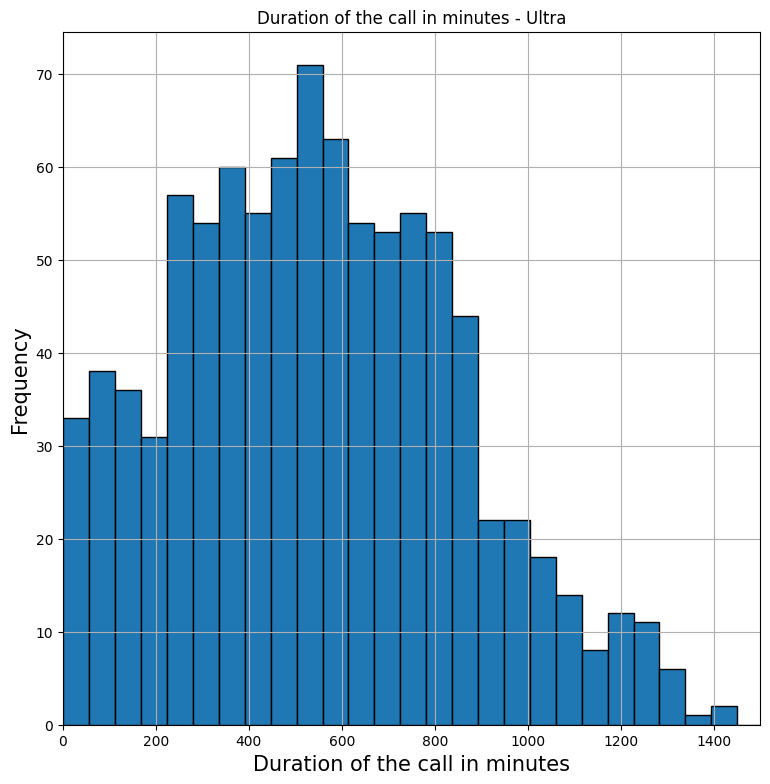

In [237]:
# Plot of the number of minutes of conversation
ultra['duration'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Duration of the call in minutes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 1500])
plt.title("Duration of the call in minutes - Ultra")
plt.show()



In [238]:
# statistical data 
ultra['duration'].describe()

count     936.000000
mean      551.708333
std       304.979493
min         1.000000
25%       319.500000
50%       533.000000
75%       760.250000
max      1673.000000
Name: duration, dtype: float64

In [239]:
# overall amount of minutes
ultra['duration'].sum()

516399.0


The total duration of calls on the Ultra tariff is 516,399 minutes. On average, clients use 551 minutes of voice per month. Considering that the Ultra tariff includes 3,000 included and prepaid minutes, and the maximum duration of a call is 1,673, we can conclude that if clients exceed the prepaid limit, it happens very rarely and as an exception.


I'm looking at how the minutes of conversation look like for the Smart plan.

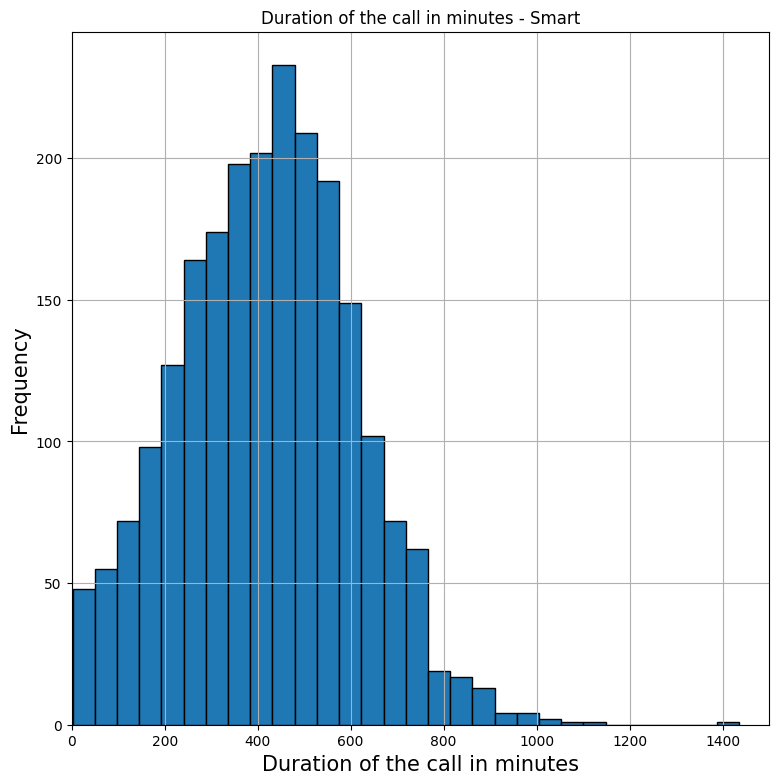

In [240]:
# Plot of the number of minutes of conversation
smart['duration'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Duration of the call in minutes', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xlim([0, 1500])
plt.title("Duration of the call in minutes - Smart")
plt.show()

In [241]:
# statistical data
smart['duration'].describe()

count    2219.000000
mean      419.776476
std       188.745325
min         2.000000
25%       285.500000
50%       423.000000
75%       546.000000
max      1435.000000
Name: duration, dtype: float64

In [242]:
# overall amount of minutes
smart['duration'].sum()

931484.0

The total duration of calls on the Smart tariff is 931,484 minutes. On average, clients use 419 minutes of voice per month. Considering that the Smart tariff includes 500 included and prepaid minutes, and the maximum duration is 1,673, we can conclude that clients on this tariff are either very close to the prepaid minute limit or often exceed the prepaid limit.

In [243]:
# Let's check the number of customers who exceeded the prepaid limit.
smart.query('duration>500').count()

user_id                  754
month                    754
duration                 754
calls_amount             754
mb_used                  754
messages_amount          754
tariff                   754
city                     754
messages_included        754
mb_per_month_included    754
minutes_included         754
rub_monthly_fee          754
rub_per_gb               754
rub_per_message          754
rub_per_minute           754
extra_expenses           754
income                   754
dtype: int64


Around 33% of the total number of customers using the Smart tariff exceed the prepaid limit.







I'm gathering all the information about calls into one table, adding the standard deviation and variance.

In [244]:
# table with data on the mean, median, standard deviation, and variance
clients_total.groupby('tariff')\
     .agg({'duration':['median','mean','var','std']})\
     .style.format("{:.1f}")

## Internet 


I'm looking at the information about the volume of traffic for the Ultra plan.

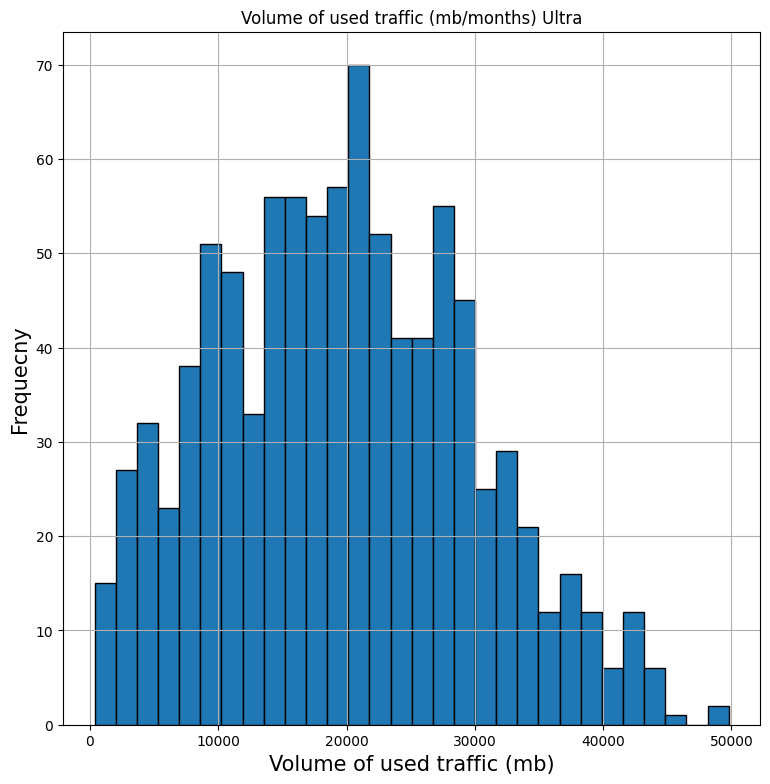

In [245]:
# Plot of the volume of traffic for calls
ultra['mb_used'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Volume of used traffic (mb)', fontsize=15)
plt.ylabel('Frequecny', fontsize=15)
plt.title("Volume of used traffic (mb/months) Ultra")
plt.show()

In [246]:
# statistical data
ultra['mb_used'].describe()

count      936.000000
mean     19718.717949
std       9972.317787
min        366.000000
25%      11917.000000
50%      19445.000000
75%      26958.500000
max      49789.000000
Name: mb_used, dtype: float64

In [247]:
# overall volume mb
ultra['mb_used'].sum()

18456720.0


The total volume of traffic on the Ultra tariff is 18,440,066 MB. On average, clients use 19,700 MB of traffic per month. Considering that the Ultra tariff includes 30,720 included and prepaid MB, and the maximum usage is 49,746 MB, we can conclude that there are clients who exceed the prepaid amount.

In [248]:
# number of customers who exceeded the limit.
ultra.query('mb_used > 30720').count()

user_id                  128
month                    128
duration                 128
calls_amount             128
mb_used                  128
messages_amount          128
tariff                   128
city                     128
messages_included        128
mb_per_month_included    128
minutes_included         128
rub_monthly_fee          128
rub_per_gb               128
rub_per_message          128
rub_per_minute           128
extra_expenses           128
income                   128
dtype: int64

There are about 13% of customers, out of the total number of customers using the Ultra plan, who exceeded the limit.


I'm looking at the information about the volume of traffic for the Smart plan.

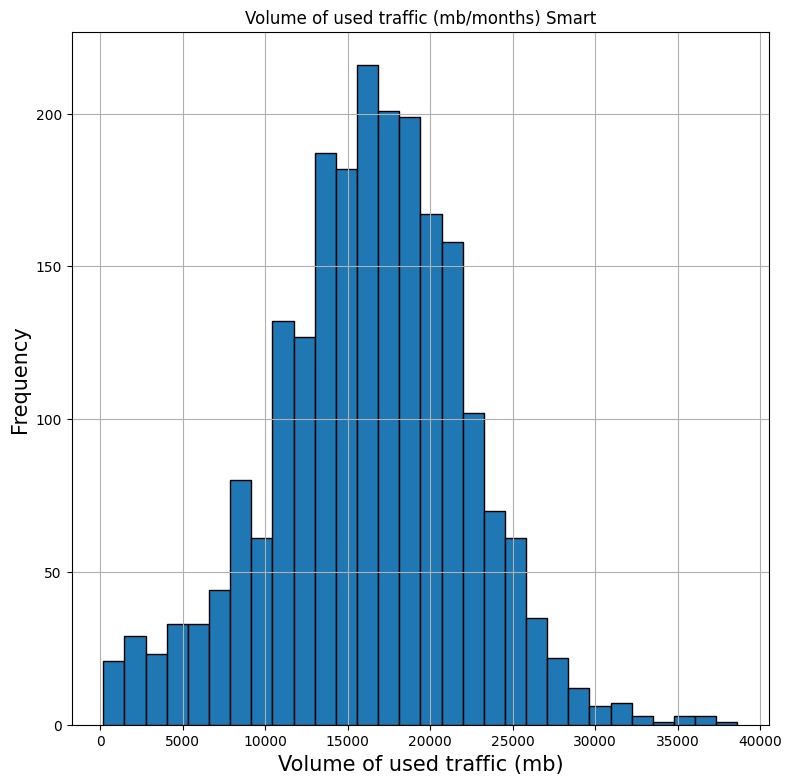

In [249]:
# Plot of the volume of traffic for calls
smart['mb_used'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Volume of used traffic (mb)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Volume of used traffic (mb/months) Smart")
plt.show()

In [250]:
# statistical data
smart['mb_used'].describe()

count     2219.000000
mean     16246.091933
std       5865.865927
min        202.000000
25%      12686.500000
50%      16531.000000
75%      20074.000000
max      38610.000000
Name: mb_used, dtype: float64

In [251]:
# overall volume mb
smart['mb_used'].sum()

36050078.0


The total volume of traffic on the Smart plan is 36,004,953 MB. On average, clients use 16,225 MB of traffic per month. Considering that the Smart plan includes 15,360 included and prepaid MB, and the maximum usage is 38,553 MB, we can conclude that there are clients who exceed the prepaid amount.

In [252]:
# the number of customers who exceeded the limit
smart.query('mb_used > 15360').count()

user_id                  1304
month                    1304
duration                 1304
calls_amount             1304
mb_used                  1304
messages_amount          1304
tariff                   1304
city                     1304
messages_included        1304
mb_per_month_included    1304
minutes_included         1304
rub_monthly_fee          1304
rub_per_gb               1304
rub_per_message          1304
rub_per_minute           1304
extra_expenses           1304
income                   1304
dtype: int64


There are about 60% of customers, out of the total number of customers using the Smart tariff, who exceeded the limit.


I'm adding all the information about traffic into one table, adding the standard deviation and variance.

In [253]:
# таблица с данными о среднем, медианном, стандартном отклонении и дисперсии
clients_total.groupby('tariff')\
     .agg({'mb_used':['median','mean','var','std']})\
     .style.format("{:.1f}")

## Messages 

Смотрю информацию по объему сообщений для тарифа Ultra.

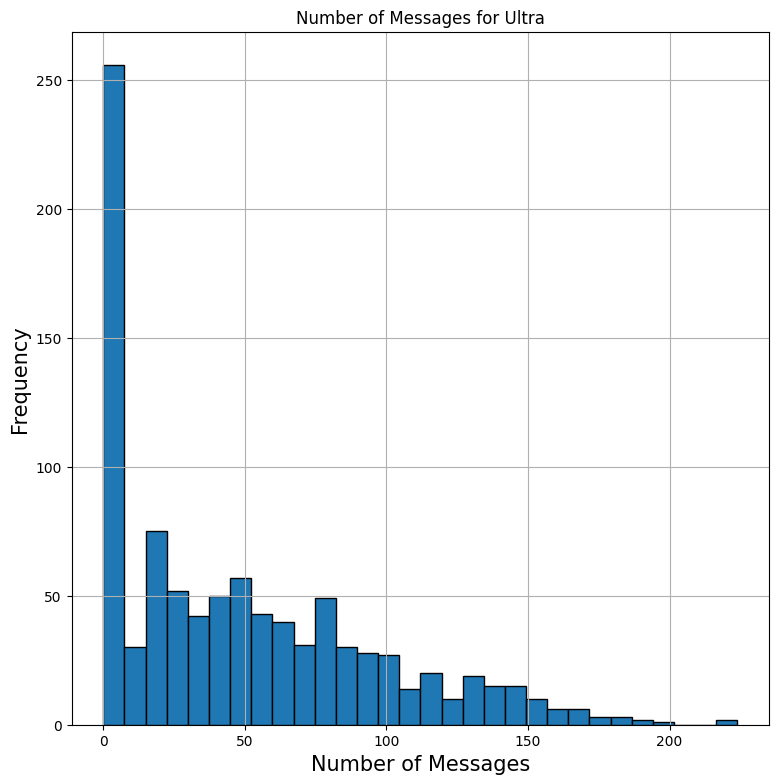

In [254]:
# Plot of the number of messages
ultra['messages_amount'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Number of Messages', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Number of Messages for Ultra")
plt.show()


In [255]:
# statistical data
ultra['messages_amount'].describe()

count    936.000000
mean      49.033120
std       46.778211
min        0.000000
25%        5.000000
50%       39.500000
75%       79.000000
max      224.000000
Name: messages_amount, dtype: float64


In the column, there are quite a few 0 values, indicating that many customers only use calls or exchange messages through messaging apps, and therefore, they spend more on internet usage. To understand how close the mean value is to the truth, let's also look at the median, which is more robust to outliers.

In [256]:
# checking median
ultra['messages_amount'].median()

39.5


It turns out that there is a difference of approximately 10 messages per client. From my point of view, this is a significant difference that can affect the revenue. Therefore, for the analysis, I will use the more robust median, which is less sensitive to outliers.

In [257]:
# The total number of messages.
ultra['messages_amount'].sum()

45895.0


The total number of messages on the Ultra tariff is 45,895. On average, clients send around 40 messages per month. Considering that the Ultra tariff includes 1,000 included and prepaid messages, and the maximum value of sent messages is 224, we can conclude that clients rarely exceed the prepaid message limit.


I'm looking at the information about the volume of messages for the Smart plan.

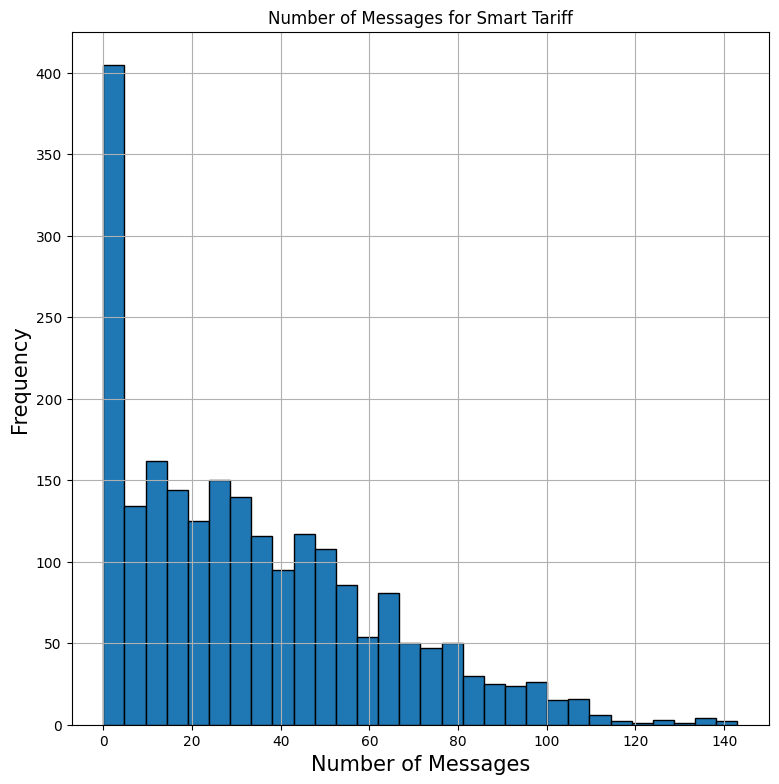

In [258]:
# Plot of the number of messages
smart['messages_amount'].plot(kind='hist', ec='black', bins=30, figsize=(9, 9), grid=True)
plt.xlabel('Number of Messages', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title("Number of Messages for Smart Tariff")
plt.show()


In [259]:
# stat data
smart['messages_amount'].describe()

count    2219.000000
mean       33.421361
std        28.266229
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages_amount, dtype: float64

The situation with the mean value and median is the same as for the Ultra tariff. Let's see how big the difference is.

In [260]:
# checking median
smart['messages_amount'].median()

28.0


The difference is about 3 messages, and I think it's not a significant difference. Therefore, both the mean value and the median can be used in this case.

In [261]:
# total amount of messages
smart['messages_amount'].sum()

74162.0

The total number of messages on the Ultra tariff is 74,162. On average, clients send around 30 messages per month. Considering that the Ultra tariff includes 50 included and prepaid messages, and the maximum value of sent messages is 143, we can conclude that some customers exceed the limit.

In [262]:
# checking the number of customers who exceeded the limit.
smart.query('messages_amount > 50').count()

user_id                  564
month                    564
duration                 564
calls_amount             564
mb_used                  564
messages_amount          564
tariff                   564
city                     564
messages_included        564
mb_per_month_included    564
minutes_included         564
rub_monthly_fee          564
rub_per_gb               564
rub_per_message          564
rub_per_minute           564
extra_expenses           564
income                   564
dtype: int64

There are approximately 25% of customers, out of the total number of customers using the Smart plan, who exceeded the limit.

I will gather all the indicators about messages into one table, and add the standard deviation and variance.

In [263]:
# checking data on messages
clients_total.groupby('tariff')\
  .agg({'messages_amount':['median','mean','var','std']})\
  .style.format("{:.1f}")


Overall Conclusion: Customers on the Smart tariff exceed the prepaid limit more often compared to the Ultra tariff when all the data is combined and analyzed.

|Plan/|Extra calls|Extra Mb|Extra messages|
|----|----|----|----|
|Ultra|0% |13% |0% |
|Smart|33% |60% |25%|

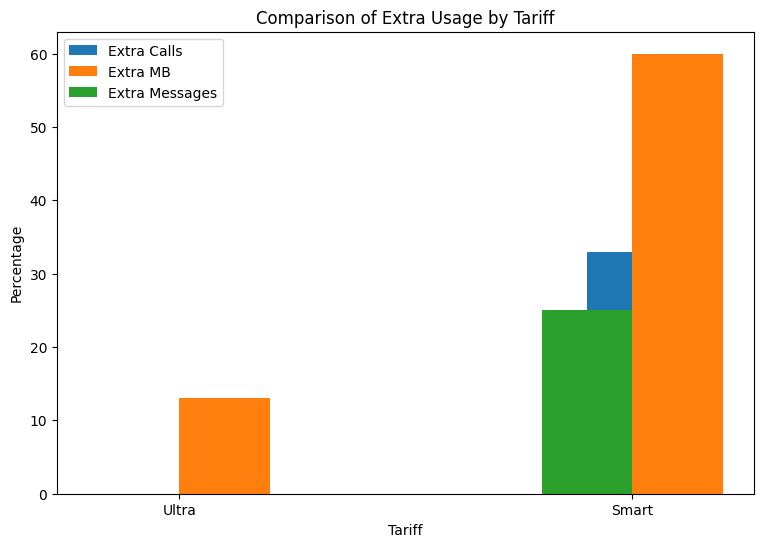

In [264]:
# Data
plans = ['Ultra', 'Smart']
extra_calls = [0, 33]
extra_mb = [13, 60]
extra_messages = [0, 25]

# Plotting
plt.figure(figsize=(9, 6))
plt.bar(plans, extra_calls, width=0.2, label='Extra Calls', align='center')
plt.bar(plans, extra_mb, width=0.2, label='Extra MB', align='edge')
plt.bar(plans, extra_messages, width=-0.2, label='Extra Messages', align='edge')

# Formatting
plt.xlabel('Tariff')
plt.ylabel('Percentage')
plt.title('Comparison of Extra Usage by Tariff')
plt.legend()

# Displaying the plot
plt.show()


# Hypothesis Testing: Average Revenue


Let's compare the variances of the samples to determine the value of the equal_var argument.

In [265]:
# table with data on the mean, median, standard deviation, and variance.
clients_total.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

The difference is significant, therefore 'equal_var' = False.

The task is to test the hypothesis: the average revenue from Ultra and Smart tariff users differs.

* H0: the revenue from Ultra and Smart tariff users does not differ
* H1: the revenue from Ultra and Smart tariff users differs

Since the two samples are independent, I am using the Student's t-test.

First, let's check the revenue data for outliers. In my opinion, a boxplot is best for this purpose.

<Axes: title={'center': 'income'}, xlabel='tariff'>

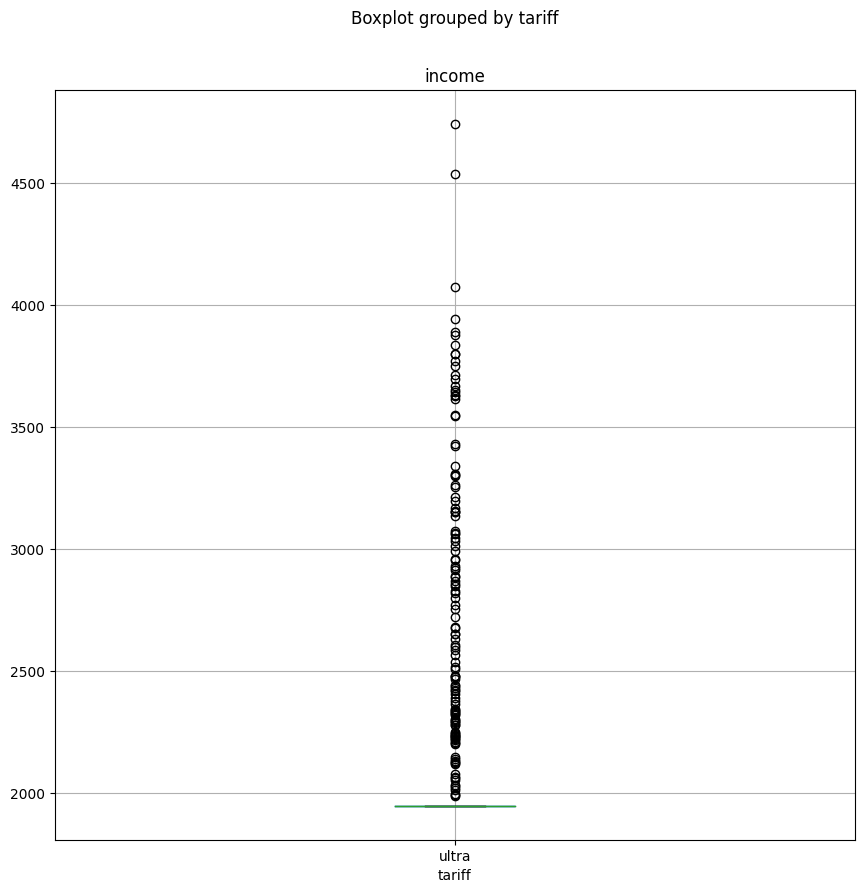

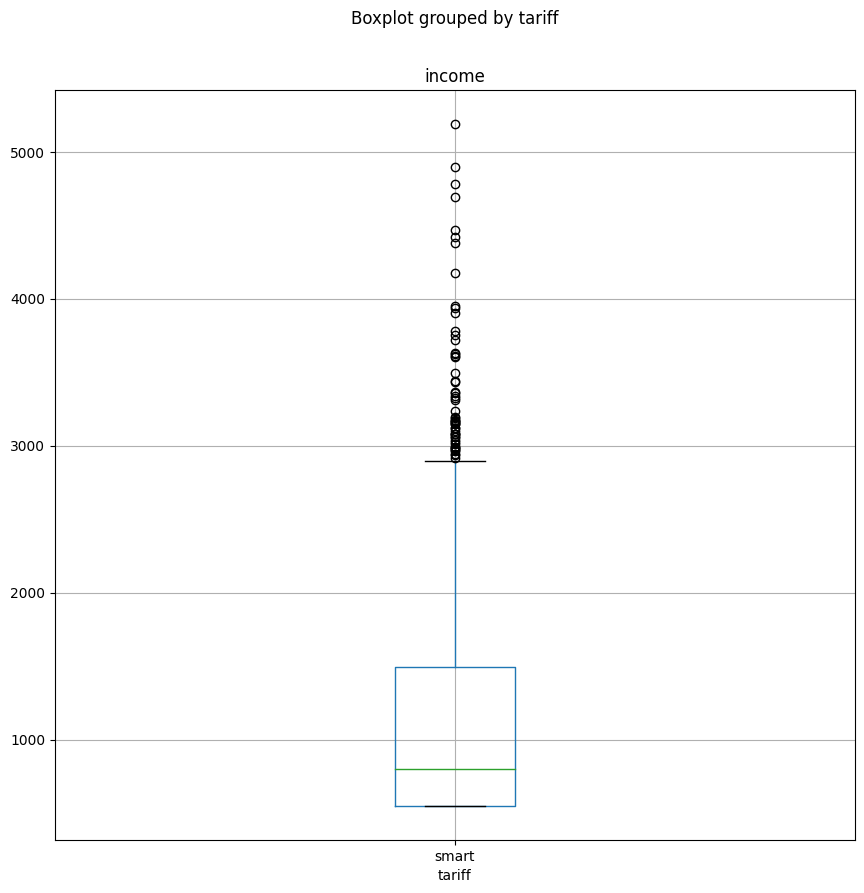

In [266]:
# скуфештп Boxplot to check for outliers
ultra.boxplot('income', by='tariff', figsize=(10,10))
smart.boxplot('income', by='tariff', figsize=(10,10))



e graphs look strange, but most importantly, it is visible that there are outliers that can distort the data.

To remove outliers, I use a function that identifies them based on quartiles and removes the extra data

In [267]:
# function to identify outliers 
def remove_outlier(df, column, show_plot=False, x = 10, y = 10):
    # assign quartile values to variables
    low_quartile, upper_quartile = df[column].quantile([0.25, 0.75])
    inter_quartile_range = upper_quartile - low_quartile
    # use Interquartile Rule to Find Outliers: https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244
    in_range = df[column].between(low_quartile - 1.5 * inter_quartile_range, 
                                  upper_quartile + 1.5 * inter_quartile_range)
    if show_plot:
        return df.loc[in_range].boxplot(column, figsize=(x,y))
    else:
        return df.loc[in_range]

    

In [268]:
# removing outliers
ultra = remove_outlier(ultra, 'income', 0)
ultra_income = ultra['income']

smart = remove_outlier(smart, 'income', 0)
smart_income = smart['income']

<Axes: title={'center': 'income'}, xlabel='tariff'>

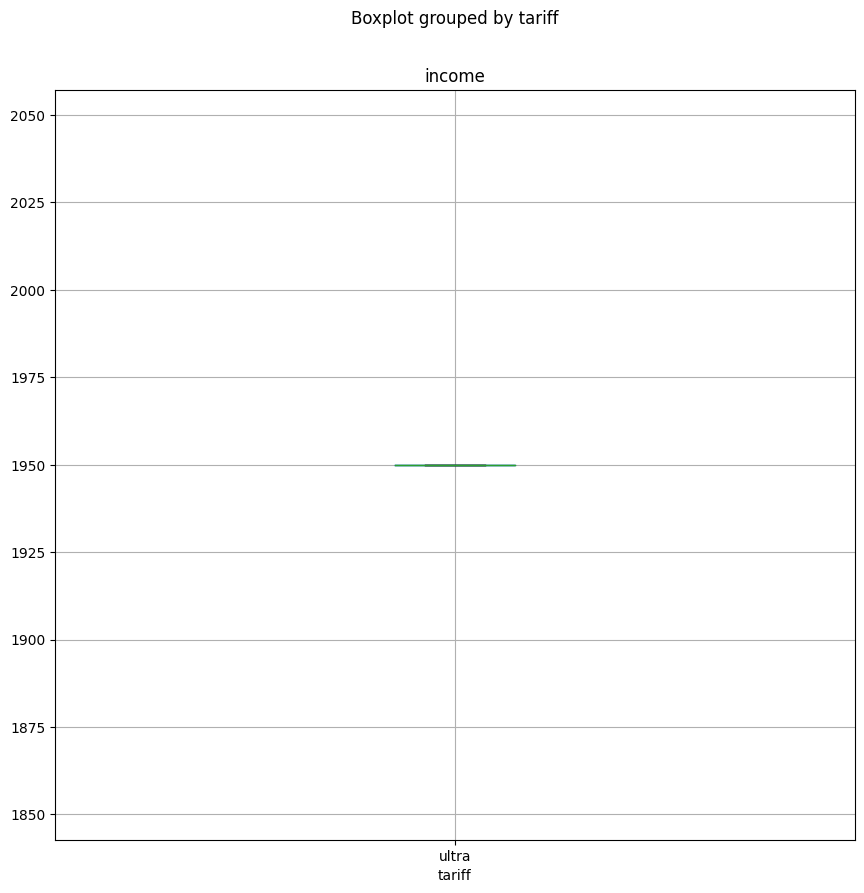

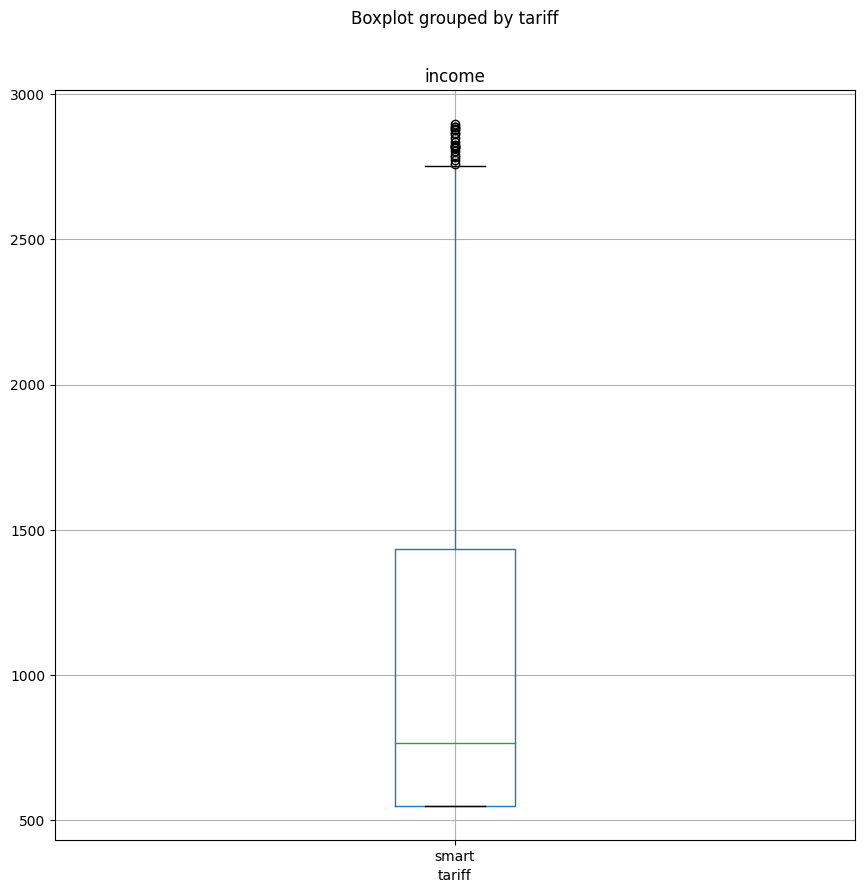

In [269]:
# checking results
ultra.boxplot('income', by='tariff', figsize=(10,10))
smart.boxplot('income', by='tariff', figsize=(10,10))

It seems like there are fewer outliers, so you can proceed to the hypothesis testing.

In [270]:
# hypothesis testing
alpha = 0.05
result = st.ttest_ind(ultra_income, smart_income, equal_var=False)

if result.pvalue < alpha:
    print('p-value:', result.pvalue)
    print('Отвергаем H0')
else:
    print('p-value:', result.pvalue)
    print('Отвергаем H1')

p-value: 0.0
Отвергаем H0


<ipython-input-270-5f65e3994c15>:3: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  result = st.ttest_ind(ultra_income, smart_income, equal_var=False)



The significance of the p-value is very low, we reject the null hypothesis.

Conclusion: The average revenue of Smart and Ultra tariffs differs.


Out of curiosity, I'll calculate the revenue by plan


In [271]:
# revenue by plan
clients_total.pivot_table(index='tariff', values='income', aggfunc=['sum','mean', 'median'])

,sum,mean,median
,income,income,income
tariff,,,
smart,2461788,1109.413249,796
ultra,1931146,2063.190171,1950


# Hypothesis testing: revenue by cities

Задача проверить гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

* H0: выручка компании в Москве и других регионах одинаковая
* H1: выручка в Москве и других региона различается

Так как две выборки независимы, использую Student t-test.

In [272]:
# проверяем названия городов
clients_total['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Каких-то странных опечаток и прочего нет, поэтому делим на две таблицы - Москва и все остальное.

In [273]:
# создаем отдельные таблицы
msc = clients_total[clients_total['city'] == 'Москва']
prv = clients_total[clients_total['city'] != 'Москва']

#проверю результат на одной таблице, если с ней все ок, то и со второй тоже все должно быть ок
msc.head(10)

,user_id,month,duration,calls_amount,mb_used,messages_amount,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_expenses,income
8,1001,11,430.0,45.0,18452.0,0.0,smart,Москва,50,15360,500,550,200,3,3,603.90625,1153
9,1001,12,414.0,47.0,14053.0,0.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550
17,1003,8,380.0,43.0,8571.0,37.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
18,1003,9,961.0,105.0,12479.0,91.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
19,1003,10,855.0,97.0,14779.0,83.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
20,1003,11,824.0,95.0,11368.0,94.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
21,1003,12,802.0,88.0,10132.0,75.0,ultra,Москва,1000,30720,3000,1950,150,1,1,0.00000,1950
53,1007,4,198.0,21.0,8031.0,11.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550
54,1007,5,480.0,57.0,17708.0,39.0,smart,Москва,50,15360,500,550,200,3,3,458.59375,1008
55,1007,6,545.0,55.0,13674.0,26.0,smart,Москва,50,15360,500,550,200,3,3,0.00000,550


Смотрим, какое значение должно быть у `equal_var`.

In [274]:
# таблица с данными  стандартном отклонении и дисперсии для москвы
msc.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

In [275]:
# таблица с данными  стандартном отклонении и дисперсии для москвы
prv.groupby('tariff')\
     .agg({'income':['var','std']})\
     .style.format("{:.1f}")

Различие есть, значит 'equal_var' = False

In [276]:
# удаляем выбросы 
msc = remove_outlier(msc, 'income', 0)
msc_income = msc['income']

prv = remove_outlier(prv, 'income', 0)
prv_income = prv['income']

In [277]:
#проверяем гипотезу
alpha = 0.05
result = st.ttest_ind(msc_income, prv_income, equal_var=False)

if result.pvalue < alpha:
    print('p-value:', result.pvalue)
    print('Отвергаем H0')
else:
    print('p-value:', result.pvalue)
    print('Отвергаем H1')

p-value: 0.0897427305729071
Отвергаем H1


Значимость p-value равна 1, отвергаем не нулевую гипотезу.

Вывод: средняя выручка тарифов Smart и Ultra в Москве и регионах не отличается.

# <a name="conclustion">Общий вывод</a>

На основе проведённого анализа данных, можно сделать следующие выводы:

Общая выручка от тарифов Smart и Ultra различаются:

**тариф Smart** приносит больше общего дохода. Возможно, это связано с тем, что клиенты (которых больше в моей выборке) чаще превышают заложенные в тарифы лимиты и поэтому чаще платят за дополнительные сообщения, минуты разговора и гигабайты интернета. Думаю из-за того, что основная прибыль от этого тарифа основана на переплате, показатель может быть нестабильным - сегодня клиенты переплатили, а завтра уложились в лимиты - прибыль сразу упадёт. 

**тариф Ultra** на первый взгляд приносит меньше дохода, но медиана и средний показатели прибыли у него выше. Так как клиенты этого тарифа реже переплачивают за выход за рамки лимитов, доход от этого тарифа более стабилен. А если привлечь к нему больше клиентов, то и выручка будет больше. Все же в моей выборке клиентов тарифа Ultra было меньше половины.
    
Превышение лимитов  в зависимости от тарифа:
     
|Тариф|св. тар. звонки|св. тар. интернет|св. тар. сообщения|
|----|----|----|----|
|Ultra|0% |13% |0% |
|Smart|33% |60% |25%|

Прибыль в зависимости от тарифа:

|Тариф|общая|средняя|медиана|
|----|----|----|----|
|Ultra|1930532 |2062 |1950 |
|Smart|2455453|1106 |792|
    
    
Выручка в Москве и регионах не отличается. Поэтому тарифы выгодно одинаково развивать как в Москве так и вне Москвы. 


Не совсем понятно, что имелось ввиду под "сообщениями", поэтому я предположила что sms. Клиенты тарифов часто вообще не пользуются этой функцией, видимо общаясь через мессенджеры. Я бы обратила на это внимание, чтобы как-то увеличить прибыль от тарифов. Например, добавила бы в тариф "Ультра" бесплатный трафик для трех-четырех популярных мессенджеров, чтобы привлечь больше клиентов.


Основная рекомендация оператору - обратить внимание на тариф Ultra и подумать как привлечь к нему больше клиентов, обратить внимание на тариф Smart и подумать как стабилизировать от этого тарифа прибыль.

<div class="alert alert-success">
<h2> Комментарий ревьюера </h2>

Выводы описаны грамотно. Приведены ответы на главные вопросы проекта. В выводах можно приводить полученные ранее значения, правильно. Здорово, что по каждому пункту работы приведен вывод, а также то, что ты привела рекомендации для компании. Это очень важно. 

</div>

<div class="alert alert-warning">
<h2> Комментарий ревьюера </h2>

Если тебе нравится тема визуализации, то можешь изучить методы библиотеки seaborn. Она позволяет строить довольно презентабельные графики.

Ты проделала большую работу, молодец! Критических замечаний немного. Однако с ними важно поработать. Также есть достаточное число желтых комментариев. Думаю, исправить их тебе не составит труда. Жду твою работу :)

</div>

<div class="alert alert-info" role="alert">
Нравится, но если я начну ковыряться, я никогда ничего не сдам! XD к тому же там какие-то сложности были с работой seaborn в я.практикум окружении. Так что думаю, оставлю на самостоятельное изучение.
Еще раз спасибо за все комментарии, не знаю кака я так просмотрела супер-важные вещи. Видимо не стоит заниматься статистикой на ночь глядя. :)
</div>

<div class="alert alert-success">
<h2> Комментарий ревьюера 2</h2>

Помарки исправлены, и теперь работа выполнена хорошо. Ты здорово поработала, молодец. Проект получился классным! Спасибо за оставленные комментарии. Успехов в дальнейших проектах :)

</div>
   